# Retail Giant Sales Forecasting

Tasks to be done:
- First, you need to do data preparation (basically here we need to merge the market and segment columns, and get the dataset in terms of 21 unique market segments. The dataset will have another column “Market Segment” added, along with Order-Date, Market, Segment, Sales, Quantity, Profit). In this step, you will also have to convert the order date into year and month format.
- After the initial data preparation, you will then calculate the coefficient of variation values for all the 21 market segments and find the best market segment with least coefficient of variation for profit.
- Based on the most profitable market segment found, you will forecast sales and quantity for that market segment. You will first refer to the flow chart and explain which models can be used for forecasting the sales and the quantity depending on your data. Soon you will apply all the models from smoothing techniques and ARIMA techniques and conclude your results on the basis of the forecast plot and the MAPE values. Here, you will also validate your results from the methods you found most suitable using the flowchart.
- You will conclude by identifying a best plot from the smoothing technique and one from the Auto Regressive techniques that work well for both the sales and quantity forecast.


## Importing the Libraries

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # supress warnings

## Reading the Dataset

In [ ]:
data = pd.read_csv('/content/drive/My Drive/TSF assignment updated/Global+Superstore+Data.csv')

In [ ]:
data.shape # 51290 transactions and 6 features

(51290, 5)

In [ ]:
data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


Since we need to do a monthly forecast, we first need to convert the transaction level data to monthly times series data. 

### Getting the data in the required Month-Year format

In [ ]:
#data['Order Date'] = pd.to_datetime(data['Order Date']).dt.to_period('m')
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y').dt.to_period('m')

In [ ]:
data.head()

,Order Date,Segment,Market,Sales,Profit
0,2012-07,Consumer,US,2309.650,762.1845
1,2013-02,Corporate,APAC,3709.395,-288.7650
2,2013-10,Consumer,APAC,5175.171,919.9710
3,2013-01,Home Office,EU,2892.510,-96.5400
4,2013-11,Consumer,Africa,2832.960,311.5200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Order Date  51290 non-null  period[M]
 1   Segment     51290 non-null  object   
 2   Market      51290 non-null  object   
 3   Sales       51290 non-null  float64  
 4   Profit      51290 non-null  float64  
dtypes: float64(2), object(2), period[M](1)
memory usage: 2.0+ MB


## Merging the market and segment columns

In [ ]:
data["Market"].unique() # Segments according to geography

array(['US', 'APAC', 'EU', 'Africa', 'EMEA', 'LATAM', 'Canada'],
      dtype=object)

In [ ]:
data["Segment"].unique() # Segments according to customer

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [ ]:
data["Concate"] = data["Market"] + data["Segment"]
data.head()

,Order Date,Segment,Market,Sales,Profit,Concate
0,2012-07,Consumer,US,2309.650,762.1845,USConsumer
1,2013-02,Corporate,APAC,3709.395,-288.7650,APACCorporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APACConsumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EUHome Office
4,2013-11,Consumer,Africa,2832.960,311.5200,AfricaConsumer


In [ ]:
data['Concate'].unique()

array(['USConsumer', 'APACCorporate', 'APACConsumer', 'EUHome Office',
       'AfricaConsumer', 'USCorporate', 'EMEAConsumer',
       'LATAMHome Office', 'EUCorporate', 'EMEACorporate',
       'LATAMConsumer', 'EUConsumer', 'USHome Office', 'LATAMCorporate',
       'AfricaCorporate', 'APACHome Office', 'EMEAHome Office',
       'AfricaHome Office', 'CanadaCorporate', 'CanadaHome Office',
       'CanadaConsumer'], dtype=object)

We have 51290 transactions in this dataset. Instead of transaction level information, we need monthly aggregated data for sales, quantily and profit since only then can we make monthly forecasts.

### Defining a new dataset to get aggregated monthly data for profit to identify which segment to forecast for

We need to sum the profits monthwise for each unique segment. 

In [ ]:
data.head()

,Order Date,Segment,Market,Sales,Profit,Concate
0,2012-07,Consumer,US,2309.650,762.1845,USConsumer
1,2013-02,Corporate,APAC,3709.395,-288.7650,APACCorporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APACConsumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EUHome Office
4,2013-11,Consumer,Africa,2832.960,311.5200,AfricaConsumer


In [ ]:
datag = data.pivot_table(index='Order Date', values='Profit', columns='Concate', aggfunc='sum')

In [ ]:
datag.head() # summing the profits according to the months and segments
# for each month we have summed profits for each segment

Concate,APACConsumer,APACCorporate,APACHome Office,AfricaConsumer,AfricaCorporate,AfricaHome Office,CanadaConsumer,CanadaCorporate,CanadaHome Office,EMEAConsumer,EMEACorporate,EMEAHome Office,EUConsumer,EUCorporate,EUHome Office,LATAMConsumer,LATAMCorporate,LATAMHome Office,USConsumer,USCorporate,USHome Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.7,NaN,-2099.364,1555.512,116.400,-845.8290,501.9315,975.360,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,982.092,216.690,-1808.1180,2988.4065,-181.041,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,390.102,78.972,2480.5410,736.9890,503.223,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,93.900,-420.090,2496.6405,1056.1785,63.858,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,-24.270,262.968,254.0805,1586.2740,201.102,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088


In [ ]:
datag.shape # 48 months i.e. 4 years

(48, 21)

### How do we choose the segment with the best profit and minimum variability

When you have huge differences in means and want to compare their variation, it would be better to take the coefficient of variation, because it normalizes the standard deviation with respect to the mean. 

We do not want to consider the entire dataset to get the CoV since we will need to keep a part of the dataset aside for validation. 

In [ ]:
#splitting the dataset into train and test for calculation for cov
train_len = 42
train_datag = datag[0:train_len] # 42 months data used for training
test_datag = datag[train_len:] # 6 months data for validation
# No sampling done here - for time series data, maintaining the sequence is important

In [ ]:
train_datag.mean()

Concate
APACConsumer         4223.553586
APACCorporate        2556.998957
APACHome Office      1379.120743
AfricaConsumer        798.898929
AfricaCorporate       426.027286
AfricaHome Office     333.002143
CanadaConsumer        230.067500
CanadaCorporate       110.377500
CanadaHome Office     138.247500
EMEAConsumer          415.354786
EMEACorporate         172.274500
EMEAHome Office       123.249214
EUConsumer           3627.517036
EUCorporate          2251.993036
EUHome Office        1097.441500
LATAMConsumer        2252.677529
LATAMCorporate       1075.994223
LATAMHome Office      788.531853
USConsumer           2603.736252
USCorporate          1853.568607
USHome Office        1062.397424
dtype: float64

In [ ]:
np.std(train_datag)

Concate
APACConsumer         2518.944225
APACCorporate        1871.535073
APACHome Office      1446.445137
AfricaConsumer       1141.894252
AfricaCorporate       709.261893
AfricaHome Office     662.629728
CanadaConsumer        339.601099
CanadaCorporate       132.146175
CanadaHome Office     302.526945
EMEAConsumer         1128.515779
EMEACorporate        1167.958953
EMEAHome Office       747.714036
EUConsumer           2348.762579
EUCorporate          1552.403019
EUHome Office        1223.296718
LATAMConsumer        1533.362508
LATAMCorporate        947.154491
LATAMHome Office     1059.547064
USConsumer           2851.858407
USCorporate          1904.002356
USHome Office        1293.079478
dtype: float64

In [ ]:
np.std(train_datag)/train_datag.mean()

Concate
APACConsumer         0.596404
APACCorporate        0.731926
APACHome Office      1.048817
AfricaConsumer       1.429335
AfricaCorporate      1.664827
AfricaHome Office    1.989866
CanadaConsumer       1.476093
CanadaCorporate      1.197220
CanadaHome Office    2.188300
EMEAConsumer         2.716992
EMEACorporate        6.779639
EMEAHome Office      6.066684
EUConsumer           0.647485
EUCorporate          0.689346
EUHome Office        1.114681
LATAMConsumer        0.680684
LATAMCorporate       0.880260
LATAMHome Office     1.343696
USConsumer           1.095295
USCorporate          1.027209
USHome Office        1.217133
dtype: float64

In [ ]:
covs = pd.DataFrame(columns = ['Segment', 'CoV']) # Initializing a dataframe with two columns

In [ ]:
# writing a loop for cov values for all market segments
for i in datag.columns:
    #print(i)
    temp = {"Segment": i, "CoV": np.std(train_datag[i])/np.mean(train_datag[i])}
    covs = covs.append(temp, ignore_index=True)

In [ ]:
covs.head()

,Segment,CoV
0,APACConsumer,0.596404
1,APACCorporate,0.731926
2,APACHome Office,1.048817
3,AfricaConsumer,1.429335
4,AfricaCorporate,1.664827


In [ ]:
#listing cov values in the order of their market segments
covs.sort_values(by='CoV')

,Segment,CoV
0,APACConsumer,0.596404
12,EUConsumer,0.647485
15,LATAMConsumer,0.680684
13,EUCorporate,0.689346
1,APACCorporate,0.731926
16,LATAMCorporate,0.880260
19,USCorporate,1.027209
2,APACHome Office,1.048817
18,USConsumer,1.095295
14,EUHome Office,1.114681


We prefer the segment with the lowest CoV value since this segment gives the relatively stable profit over the past months which will lead to reliable forecasts.

We will extract data only for APACConsumer and forecast the sales and quatity only for this segment.

## Subsetting only the rows for APACConsumer

From here we will consider only the APACConsumer segment to forecast the 6 month sales and quantity.

In [ ]:
data1 = data.loc[data.Concate == 'APACConsumer'] # Subsetting the original data
data1.head()

,Order Date,Segment,Market,Sales,Profit,Concate
2,2013-10,Consumer,APAC,5175.171,919.971,APACConsumer
6,2011-11,Consumer,APAC,1822.080,564.840,APACConsumer
7,2012-04,Consumer,APAC,5244.840,996.480,APACConsumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APACConsumer
29,2012-02,Consumer,APAC,1878.720,582.360,APACConsumer


In [ ]:
data1.shape 

(5699, 6)

In [ ]:
data1.head()

,Order Date,Segment,Market,Sales,Profit,Concate
2,2013-10,Consumer,APAC,5175.171,919.971,APACConsumer
6,2011-11,Consumer,APAC,1822.080,564.840,APACConsumer
7,2012-04,Consumer,APAC,5244.840,996.480,APACConsumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APACConsumer
29,2012-02,Consumer,APAC,1878.720,582.360,APACConsumer


In [ ]:
#grouping all the order dates and arranging them since it is transaction level data and we need monthly aggregated data
data1 = data1.groupby(['Order Date']).sum()

In [ ]:
data1.shape

(48, 2)

In [ ]:
data1

,Sales,Profit
Order Date,,
2011-01,15711.7125,991.2825
2011-02,12910.8588,1338.8688
2011-03,19472.5632,3747.1632
2011-04,15440.3046,3846.4746
2011-05,24348.9723,3639.9423
2011-06,27260.0196,4328.2596
2011-07,15842.8317,1258.9617
2011-08,22012.2366,775.8066
2011-09,34613.1849,5181.4449


## APAC Consumer

Now, since we are considering only univariate time series, let's proceed with forecasting only the sales.

In [ ]:
print(data1.head())
print(data1.shape)

                 Sales     Profit
Order Date                       
2011-01     15711.7125   991.2825
2011-02     12910.8588  1338.8688
2011-03     19472.5632  3747.1632
2011-04     15440.3046  3846.4746
2011-05     24348.9723  3639.9423
(48, 2)


In [ ]:
#dropping all the columns and keeping only sales
data1 = data1[['Sales']]
print(data1.head())

                 Sales
Order Date            
2011-01     15711.7125
2011-02     12910.8588
2011-03     19472.5632
2011-04     15440.3046
2011-05     24348.9723


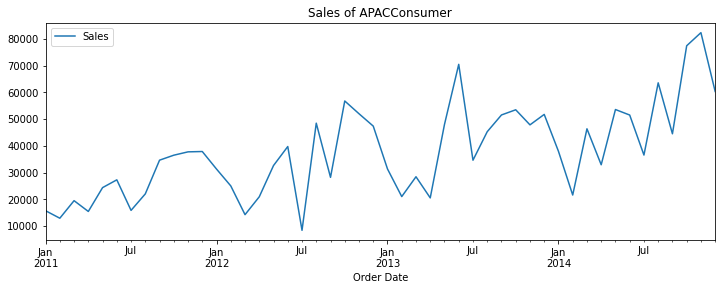

In [ ]:
#plotting the sales of APAC Consumer
data1.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales of APACConsumer')
plt.show()

Here we observe a linear trend; the seasonality is not as obvious as the airlines dataset you have studied. Lets decompose this time series to get a better idea.

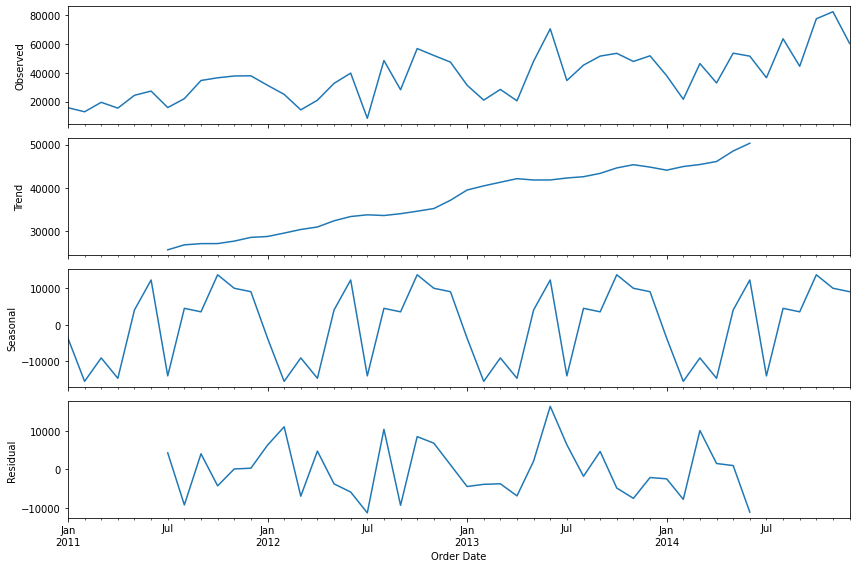

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
from statsmodels.tsa.seasonal import seasonal_decompose
data1.Sales.interpolate(inplace = True)
data1.Sales.index=data1.Sales.index.to_timestamp()
decomposition = seasonal_decompose(data1.Sales)
fig = decomposition.plot()
plt.show()

In [ ]:
#converting datetime to timestamp
data1 = data1.to_timestamp() # converting datetime to timestamp; 
                             # sometimes get error when running the models later if this step is not included

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2011-01-01 to 2014-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


# Forecasting using different algorithms

## Train-Test-Split

In [ ]:
train_len = 42
train = data1[0:train_len]
test = data1[train_len:]

## Naive Method

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1] # The last value of sales from the train data will be forecasted for test data

### Plot train, test and forecast

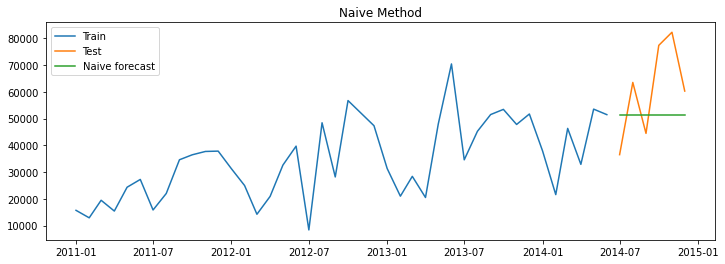

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate MAPE (Mean absolute percentage error)

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)
# take the absolute difference between the actual value and its forecast and divide by the actual value multiplied by 100 
# to get the percentage which is then rounded to two decimal places.
results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape]})
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86


## Simple average

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()

### Plot train, test and forecast

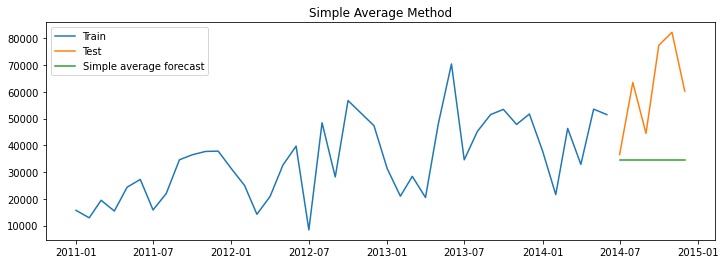

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18


## Simple Moving Average

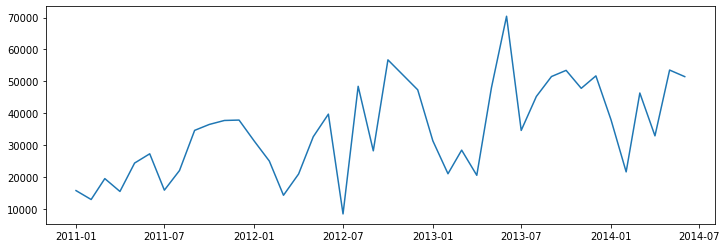

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')

In [ ]:
y_hat_sma = data1.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = data1['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

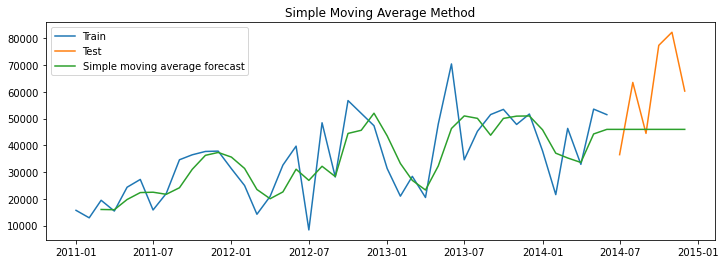

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55


## Simple Exponential Smoothing Technique

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(smoothing_level=0.2, optimized=False) # alpha = 0.2 
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_slope': None, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 15711.712500000003, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

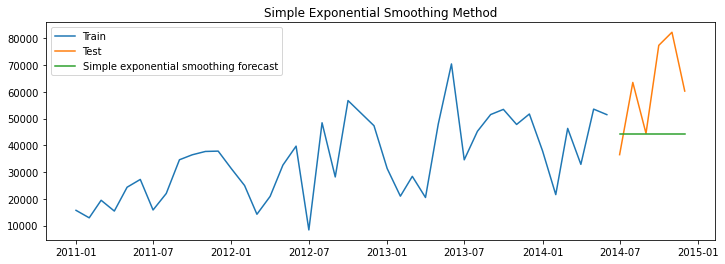

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82


It does a decent job but lets proceed with considering trend next and seasonlality further.

## Holt Method

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(np.asarray(train['Sales']),seasonal_periods=12, trend='additive', seasonal=None)
#model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.04, optimized=False)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 5.1028584231248616e-11, 'smoothing_slope': 4.883327082151558e-12, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 16493.105815548683, 'initial_slope': 809.6370957363854, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

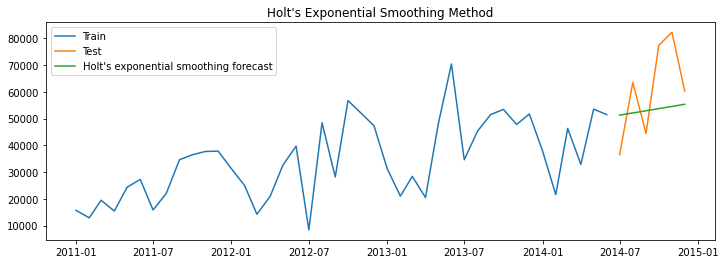

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98


# Holt Winters' additive method

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.052631578947367676, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.10526315789474944, 'damping_slope': nan, 'initial_level': 29061.291899999593, 'initial_slope': 730.4167145833245, 'initial_seasons': array([-13349.5794, -16150.4331,  -9588.7287, -13620.9873,  -4712.3196,
        -1801.2723, -13218.4602,  -7049.0553,   5551.893 ,   7410.7551,
         8661.312 ,   8785.6992]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

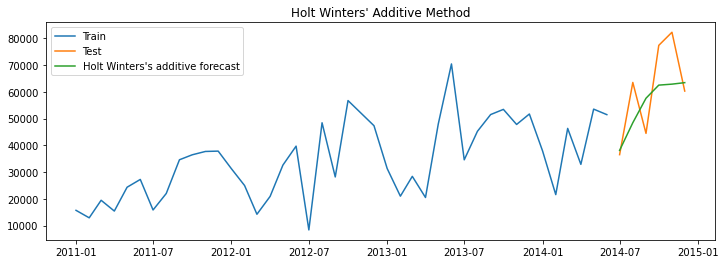

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61


# Holt Winters' Multiplicative method

In [ ]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.21052631578947367, 'damping_slope': nan, 'initial_level': 29061.291900000004, 'initial_slope': 730.4167145833347, 'initial_seasons': array([0.54064054, 0.44426307, 0.67005153, 0.53130138, 0.83784893,
       0.93801816, 0.54515235, 0.75744178, 1.19104082, 1.25500432,
       1.29803603, 1.3023162 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

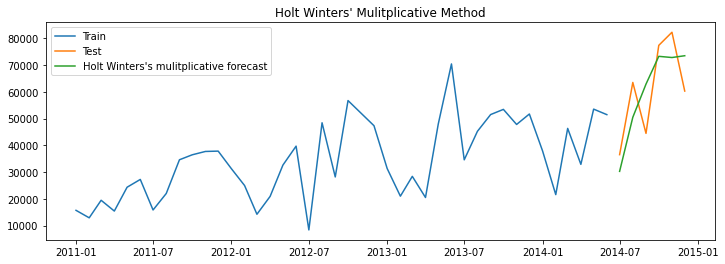

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62


# Regression Models

## Stationarity Test

In [ ]:
# Stationarity test - KPSS test
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data1['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.595515
Critical Values @ 0.05: 0.46
p-value: 0.023044


Note: Null hypothesis for KPSS test is that the series is stationary and the alternative hypothesis is that it is not stationary.

## Box Cox transformation to make variance constant

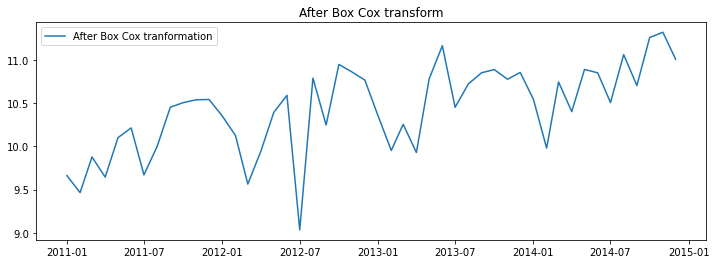

In [ ]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data1['Sales'], lmbda=0), index = data1.index) # lmbda=0 implies log transformation

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

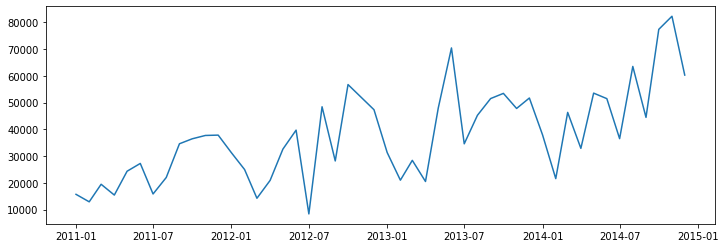

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( data1['Sales'], label='data1')

## Differencing to Remove Trend

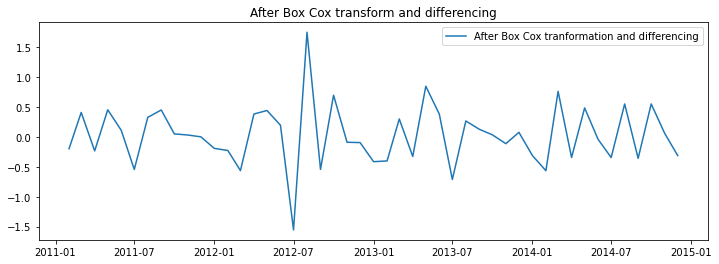

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data1.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.dropna(inplace=True)

In [ ]:
train_data_boxcox = data_boxcox[:train_len] # Arima
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len] # Rest
test_data_boxcox_diff = data_boxcox_diff[train_len:]

# Differencing and boxcox done on the entire data, hence need to split it again

In [ ]:
test_data_boxcox_diff

Order Date
2014-08-01    0.553405
2014-09-01   -0.356405
2014-10-01    0.553748
2014-11-01    0.061479
2014-12-01   -0.311004
Freq: MS, dtype: float64

## AR

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params) # gives the intercept and coefficient values

const      0.024642
ar.L1.y   -0.481508
dtype: float64


In [ ]:
# In order to make the forecast, we need to transform the forecasts made to the original form
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
# In order to get back the original time series we do a cumulative sum to remove the differencing and exponentiate the 
# forecasts in order to remove the effect of the boxcox transformation

### Plot train, test and forecast

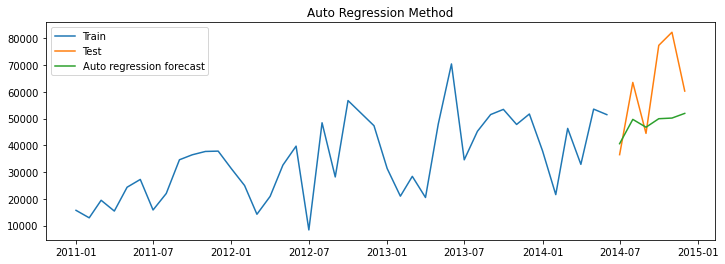

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62
0,Autoregressive (AR) method,21.07


## MA

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.021645
ma.L1.y   -0.999960
dtype: float64


In [ ]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

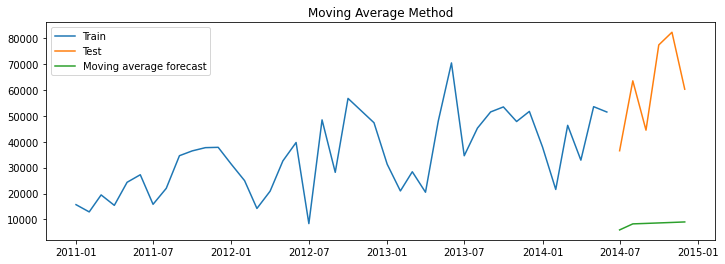

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data1['Sales'][:train_len], label='Train')
plt.plot(data1['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62
0,Autoregressive (AR) method,21.07
0,Moving Average (MA) method,85.78


## ARMA

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.021617
ar.L1.y    0.113280
ma.L1.y   -0.999930
dtype: float64


In [ ]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

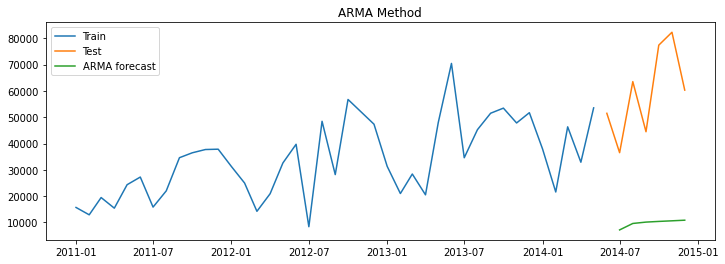

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( data1['Sales'][:train_len-1], label='Train')
plt.plot(data1['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62
0,Autoregressive (AR) method,21.07
0,Moving Average (MA) method,85.78
0,Autoregressive moving average (ARMA) method,83.00


# ARIMA

In [ ]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.022810
ar.L1.D.y    0.115922
ma.L1.D.y   -0.999999
dtype: float64


In [ ]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

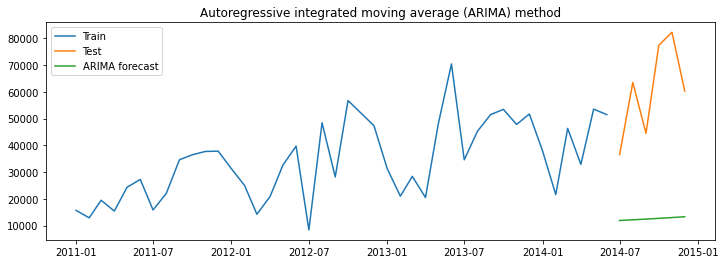

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62
0,Autoregressive (AR) method,21.07
0,Moving Average (MA) method,85.78
0,Autoregressive moving average (ARMA) method,83.00


## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.061381
ma.L1      -0.994784
ar.S.L12   -0.709435
sigma2      0.084680
dtype: float64


In [ ]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

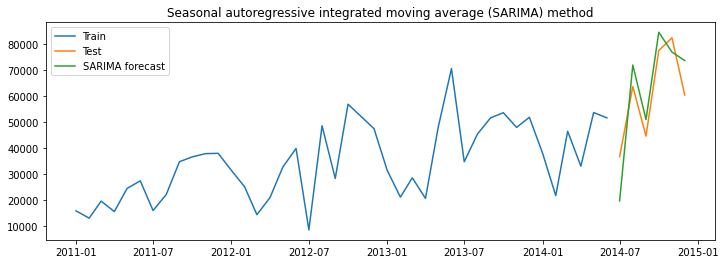

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate MAPE

In [ ]:
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)


tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Naive method,26.86
0,Simple average method,38.18
0,Simple moving average forecast,27.55
0,Simple exponential smoothing forecast,27.82
0,Holt's exponential smoothing method,24.98
0,Holt Winters' additive method,17.61
0,Holt Winters' multiplicative method,19.62
0,Autoregressive (AR) method,21.07
0,Moving Average (MA) method,85.78
0,Autoregressive moving average (ARMA) method,83.00


P, D, Q values can be changed through trial and error. You will observe that SARIMA works better than the other regression models. 